In [1]:
import numpy as np
import uproot
import pandas as pd
import awkward as ak
from tqdm import tqdm

In [2]:
with uproot.open('atmospherics_prod_1M_events_cafs_hadd_with_weights.root') as f:
    weights = f['weights'].arrays(library='pd')
    weights['nuPDG'] = ak.flatten(f['cafTree/rec/mc/mc.nu.pdg'].array())
    weights['Ev'] = ak.flatten(f['cafTree/rec/mc/mc.nu.E'].array())
    weights['NuMomX'] = ak.flatten(f['cafTree/rec/mc/mc.nu.momentum.x'].array())
    weights['NuMomY'] = ak.flatten(f['cafTree/rec/mc/mc.nu.momentum.y'].array())
    weights['NuMomZ'] = ak.flatten(f['cafTree/rec/mc/mc.nu.momentum.z'].array())
    weights['coszen'] = weights['NuMomY'] / np.sqrt(weights['NuMomX']**2 + weights['NuMomY']**2 + weights['NuMomZ']**2)

    weights['nue_unosc_w'] = weights['xsec'] * weights['nue_w']
    weights['numu_unosc_w'] = weights['xsec'] * weights['numu_w']
df = weights

In [3]:
#Get OscProb
import ROOT
ROOT.gSystem.Load('/home/seave/anaconda3/OscProb/lib/libOscProb.so')

0

In [4]:
def ConfigurePMNS(mh):
    
    myPMNS = ROOT.OscProb.PMNS_NSI()
    prem = ROOT.OscProb.PremModel()

    # Set basic oscillation parameters (Best fit as of 2024)
    dm21 = 7.49e-5
    dm31 = 2.513e-3 if mh > 0 else -2.510e-3
    th12 = np.arcsin(np.sqrt(0.308))
    th13 = np.arcsin(np.sqrt(0.02215)) if mh > 0 else np.arcsin(np.sqrt(0.02224));
    th23 = np.arcsin(np.sqrt(0.470)) if mh > 0 else np.arcsin(np.sqrt(0.562));
    dcp = 212*(np.pi/180) if mh> 0 else 285*(np.pi/180)

    myPMNS.SetMix(th12, th23, th13, dcp);
    myPMNS.SetDeltaMsqrs(dm21, dm31); 

    return myPMNS, prem

In [5]:
def Get_Prob(E, coszen, mh, flav_in, flav_out, nsiDict, is_antinu):
  
  myPMNS, prem = ConfigurePMNS(mh)
    
  if is_antinu:
    myPMNS.SetIsNuBar(True)
  #Set epsilon and delta values to given nsi param
  
  if nsiDict is None:    
    
    # Explicitly zero NSI
    myPMNS.SetEps_emu(0.0, 0.0)
    myPMNS.SetEps_etau(0.0, 0.0)
    myPMNS.SetEps_mutau(0.0, 0.0)
  
  else:
      nsi_param = list(nsiDict.keys())[0]
      epsilon, delta = nsiDict[nsi_param] 
      
      if nsi_param == 'eps_emu':
          myPMNS.SetEps_emu(epsilon, delta)
      elif nsi_param == 'eps_etau':
          myPMNS.SetEps_etau(epsilon, delta)
      elif nsi_param == 'eps_mutau':
          myPMNS.SetEps_mutau(epsilon, delta)
      else:
          print("Invalid NSI Parameter")

  #Get total length of path and set path through earth
  L = prem.GetTotalL(coszen)
  prem.FillPath(coszen);
  myPMNS.SetPath(prem.GetNuPath());

  prob =  myPMNS.Prob(flav_in, flav_out, L/E)
  return prob

In [6]:
def Make_NSI_Dict(eps_name, eps_val, delta):
    nsiDict = {eps_name: [eps_val, delta]}
    return nsiDict

In [7]:
def Get_Expected(df, mh, flav_out, nsiDict):
    total_weighted = 0.0
    
    for _, row in df.iterrows():
        E = row['Ev']
        cz = row['coszen']
        nu_pdg = row['nuPDG']
        is_antinu = (nu_pdg < 0)
        flav_in = abs(nu_pdg)  # Use 12, 14, 16 for ν_e, ν_μ, ν_τ

        # Pick the correct unoscillated weight
        if flav_in == 12:  # ν_e or ν̄_e
            weight = row['nue_unosc_w']
            flav_in_code = 0
        elif flav_in == 14:  # ν_μ or ν̄_μ
            weight = row['numu_unosc_w']
            flav_in_code = 1
        else:
            continue 

        # Compute oscillation probability
        prob = Get_Prob(
            E, cz, mh,
            flav_in_code, flav_out,
            nsiDict,
            is_antinu
        )
        total_weighted += weight * prob

    return total_weighted


In [8]:
def RandomSampling(df):
    # the seed can be whatever we choose, 1 is used here 
    df_random = df.sample(n = 1000, random_state = 1)
    return df_random

In [10]:
eps_vals = np.linspace(0, 2, 10)
delta_vals = np.linspace(0, 2*np.pi, 10)
df_rand = RandomSampling(df)

In [28]:
#Get progress bar, will likely take some time
from tqdm import tqdm

def SensitivityMap(nsiParam, flavOut, df):
    
    sens_map = np.zeros((len(eps_vals), len(delta_vals)))
    mh = +1  # or -1 for inverted hierarchy
    df_rand = RandomSampling(df)

    # Compute standard events
    N_std = Get_Expected(df_rand, mh, flavOut, nsiDict = None)
    # Scan grid

    for i, eps in enumerate(tqdm(eps_vals, desc="Scanning ε")):
        for j, delta in enumerate(delta_vals):
        
            nsiDict = Make_NSI_Dict(nsiParam, eps, delta)
            N_nsi = Get_Expected(df_rand, mh, flavOut, nsiDict)
            sens_map[i, j] = (N_nsi - N_std)*np.abs(N_nsi - N_std) / (N_nsi)
    return sens_map

In [46]:
import matplotlib.pyplot as plt

def Plot(nsiParam,  flavOut, df):

    sens_map = SensitivityMap(nsiParam, flavOut, df)

    #Labelling
    nsiParamLatex = {
    "eps_emu": r"$\varepsilon_{e\mu}$",
    "eps_etau": r"$\varepsilon_{e\tau}$",
    "eps_mutau": r"$\varepsilon_{\mu\tau}$"}

    flavOutLatex = {0: r"$\nu_e$", 1: r"$\nu_\mu$", 2: r"$\nu_\tau$"}

    #Normalize by pi
    delta_pi_norm = delta_vals/(np.pi)

    plt.figure(figsize=(8,6))

    # Get edges
    eps_edges = np.linspace(eps_vals[0], eps_vals[-1], len(eps_vals)+1)
    delta_edges = np.linspace(delta_pi_norm[0], delta_pi_norm[-1], len(delta_pi_norm)+1)

    pcm = plt.pcolormesh(delta_edges, eps_edges, sens_map, shading='auto', cmap='viridis')
    cbar = plt.colorbar(pcm)
    
    
    cbar.set_label(r'$S_{\sigma}$', fontsize=14)
    plt.xlabel(r'$\delta_{e\mu} / \pi$', fontsize = 14)
    plt.ylabel(r'$\epsilon_{e\mu}$' , fontsize = 14)
    plt.title(fr"$S_\sigma$ for {nsiParamLatex[nsiParam]}, {flavOutLatex[flavOut]}", fontsize=16)
    
    plt.tight_layout()
    plt.show()



Scanning ε: 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


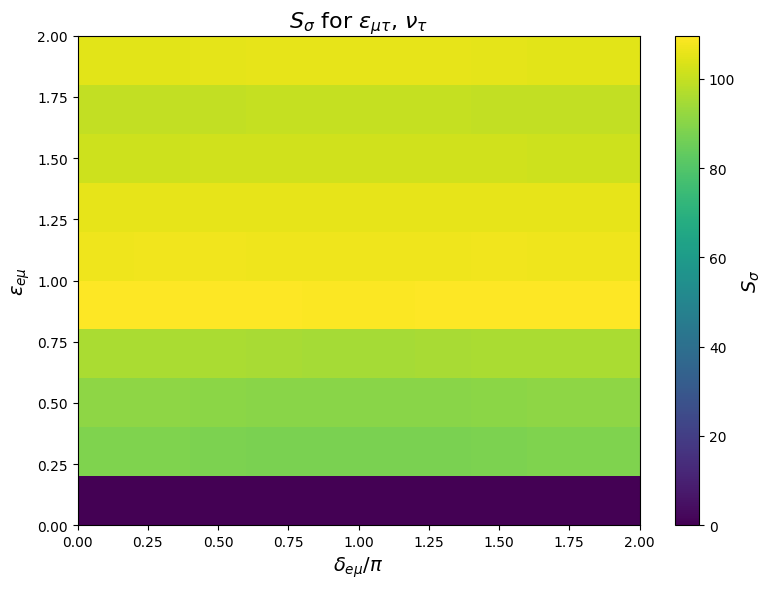

In [56]:
Plot('eps_mutau', 2, df)

Text(0, 0.5, 'N_Events')

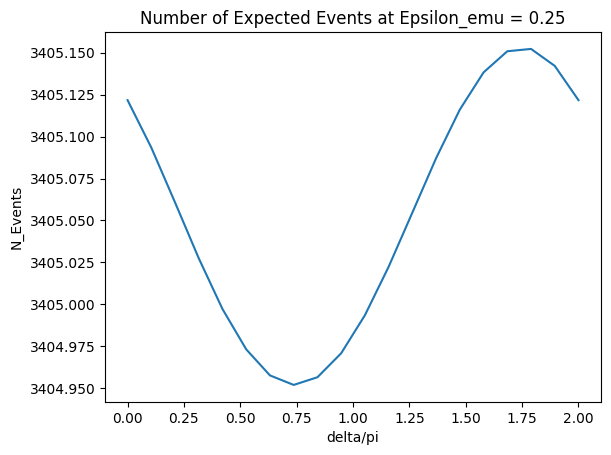

In [135]:
#Sanity check. Does varying delta create a sinusoidal pattern at a given epsilon?

deltas = np.linspace(0,2*np.pi, 20)
df_rand = RandomSampling(df)
eventList = []

for delta in deltas:
    nsiDict = Make_NSI_Dict('eps_emu', 0.25, delta)
    events = Get_Expected(df_rand, 1, 1, nsiDict)
    eventList.append(events)

eventArray = np.array(eventList)
delta_norm = deltas/(np.pi)

plt.plot(delta_norm , eventArray)
plt.title('Number of Expected Events at Epsilon_emu = 0.25')
plt.xlabel('delta/pi')
plt.ylabel('N_Events')